练习对时间序列的操作

数据集说明：

data.csv：风机叶片数据集，包含time和其他27个特征。其中time是每一条数据的时间，需要依据下面两个时间表，对每一条数据是故障或是正常或是无效数据进行判断。

failure.csv：故障风机叶片时间数据，可以据此确定15_data中每一条故障数据的标签。

normal.csv：正常工作风机叶片时间数据，可以据此确定15_data中每一条正常工作数据的标签。

叶片预测数据集中需要解决的问题：

样本中存在停机、人为删除数据、无效数据等，会造成某些时间段的数据缺失 ，如何对缺失数据与数据不均匀问题进行处理？此外，叶片正常(normalInfo)与结冰故障(failureInfo)数据不均衡，该如何处理？

选取哪些特征用于模型预测？

何种训练模型比较适合本问题？

在建立预测分类模型的时候，需要考虑风机结冰数据的类 不平衡问题。一般来说，对数据进行重采样能够有效降低类不 平衡带来的建模误差。将结冰样本进行过采样，将非结冰样本 进行欠采样，或者两者同时进行，以达到结冰和非结冰样本在 模型训练时有基本相近的比例。

如果我们能从序列数据中提取出易于分类的特征，就能够 准确地检测早期结冰。因此，在设计预测模型时，不仅要提供 瞬态特征，还要利用滑动窗提取给定长度下的统计特征。这些 统计特征能够很好地反映这一段序列数据的演化规律和状态， 因此能够更好的发现早期结冰。

我们根据训练数据中的 group 维度随机 地删除部分非结冰数据以及结冰严重数据，经过剔除数据处理， 正负样本所占比依然存在很大的差异，这种数据不平衡会对模 型最终的叶片结冰预测有非常大的影响，一般处理方式有三种:

欠采样、过采样、在模型 loss 函数中增加惩罚项以及模型集成。由于我们想尽可能的保留原始数据，因此选择第三种方法， 并且选取了更加适合此种情况的评价函数。

In [4]:
import pandas as pd 
import numpy as np
import pickle

data = pd.read_csv('data.csv')
fail_data = pd.read_csv('failure.csv')
normal_data = pd.read_csv('normal.csv')


In [5]:
total = len(data)
print('sum of data:%d'%total)
des = data.describe()


sum of data:393886


In [11]:
type(data)

pandas.core.frame.DataFrame

对时间标签做处理，分类出label:

label = 1: 故障时间区域

label = 0: 正常时间区域

label = -1:无效数据

在很多情况下，我们的原始数据中的时间和日期并不是时间类型的，例如excel中可能是Unicode，csv中可能是Str。因此我们在进行时间切片之前首先要将非时间类型的时间数据转换为时间类型。

In [12]:
times = []
for i in range(total):
    dt = pd.to_datetime(data.iloc[i][0])
    times.append(dt)
    if(i%10000 == 0):
        print('complete %d / %d' %(i,len(data)))
times = pd.Series(times)
data.time = times


complete 0 / 393886
complete 10000 / 393886
complete 20000 / 393886
complete 30000 / 393886
complete 40000 / 393886
complete 50000 / 393886
complete 60000 / 393886
complete 70000 / 393886
complete 80000 / 393886
complete 90000 / 393886
complete 100000 / 393886
complete 110000 / 393886
complete 120000 / 393886
complete 130000 / 393886
complete 140000 / 393886
complete 150000 / 393886
complete 160000 / 393886
complete 170000 / 393886
complete 180000 / 393886
complete 190000 / 393886
complete 200000 / 393886
complete 210000 / 393886
complete 220000 / 393886
complete 230000 / 393886
complete 240000 / 393886
complete 250000 / 393886
complete 260000 / 393886
complete 270000 / 393886
complete 280000 / 393886
complete 290000 / 393886
complete 300000 / 393886
complete 310000 / 393886
complete 320000 / 393886
complete 330000 / 393886
complete 340000 / 393886
complete 350000 / 393886
complete 360000 / 393886
complete 370000 / 393886
complete 380000 / 393886
complete 390000 / 393886


In [25]:
times

0        2015-11-01 20:20:16
1        2015-11-01 20:20:23
2        2015-11-01 20:20:30
3        2015-11-01 20:20:37
4        2015-11-01 20:20:47
5        2015-11-01 20:20:54
6        2015-11-01 20:21:01
7        2015-11-01 20:21:08
8        2015-11-01 20:21:15
9        2015-11-01 20:21:22
10       2015-11-01 20:21:29
11       2015-11-01 20:21:36
12       2015-11-01 20:21:43
13       2015-11-01 20:21:50
14       2015-11-01 20:21:57
15       2015-11-01 20:22:04
16       2015-11-01 20:22:11
17       2015-11-01 20:22:18
18       2015-11-01 20:22:25
19       2015-11-01 20:22:32
20       2015-11-01 20:22:39
21       2015-11-01 20:22:49
22       2015-11-01 20:22:56
23       2015-11-01 20:23:03
24       2015-11-01 20:23:10
25       2015-11-01 20:23:17
26       2015-11-01 20:23:24
27       2015-11-01 20:23:31
28       2015-11-01 20:23:38
29       2015-11-01 20:23:45
                 ...        
393856   2016-01-01 21:34:36
393857   2016-01-01 21:34:43
393858   2016-01-01 21:34:50
393859   2016-

In [22]:
# 转化normal_data & fail_data时间列为datetime
def to_datetime(obj_pd):
    Ser1 = obj_pd.iloc[:,0]
    Ser2 = obj_pd.iloc[:,1]
    for i in range(len(Ser1)):
        Ser1[i] = pd.to_datetime(Ser1[i])
        Ser2[i] = pd.to_datetime(Ser2[i])
    obj_pd.iloc[:,0] = Ser1
    obj_pd.iloc[:,1] = Ser2
    return obj_pd
normal_data = to_datetime(normal_data)
fail_data = to_datetime(fail_data)
    

根据datetime创建labels列表

In [27]:
labels = []
for i in range(len(times)):
    if(i%10000==0):
        print("complete %d / %d" % (i,len(times)))
    flag = 0
    for j in range(len(normal_data)):
        if((times[i] >= normal_data.startTime[j]) and (times[i] <= normal_data.endTime[j])):
            labels.append(0)
            flag = 1
            break
    for j in range(len(fail_data)):
        if(flag==1):
            break
        elif((times[i] >= fail_data.startTime[j]) and (times[i] <= fail_data.endTime[j])):
            labels.append(1)
            flag = 1
            break
    if(flag == 1):
        continue
    labels.append(-1)
print("complete all")

complete 0 / 393886
complete 10000 / 393886
complete 20000 / 393886
complete 30000 / 393886
complete 40000 / 393886
complete 50000 / 393886
complete 60000 / 393886
complete 70000 / 393886
complete 80000 / 393886
complete 90000 / 393886
complete 100000 / 393886
complete 110000 / 393886
complete 120000 / 393886
complete 130000 / 393886
complete 140000 / 393886
complete 150000 / 393886
complete 160000 / 393886
complete 170000 / 393886
complete 180000 / 393886
complete 190000 / 393886
complete 200000 / 393886
complete 210000 / 393886
complete 220000 / 393886
complete 230000 / 393886
complete 240000 / 393886
complete 250000 / 393886
complete 260000 / 393886
complete 270000 / 393886
complete 280000 / 393886
complete 290000 / 393886
complete 300000 / 393886
complete 310000 / 393886
complete 320000 / 393886
complete 330000 / 393886
complete 340000 / 393886
complete 350000 / 393886
complete 360000 / 393886
complete 370000 / 393886
complete 380000 / 393886
complete 390000 / 393886
complete all


print 数据信息

In [34]:
type(labels)

list

In [33]:
def data_judge(labels,total):
    sum_inv = 0
    for i in range(len(labels)):
        if(labels[i] == -1):
            sum_inv = sum_inv + 1
    print("sum of invalid data : %d , %.2f %%" % (sum_inv,sum_inv/total*100))
    
    sum_nor = 0
    for i in range(len(labels)):
        if(labels[i] == 0):
            sum_nor = sum_nor + 1
    print("sum of normal data : %d , %.2f %% " % (sum_nor,sum_nor/total*100))
    
    sum_fail = 0
    for i in range(len(labels)):
        if(labels[i] == 1):
            sum_fail = sum_fail + 1
    print("sum of failure data : %d , %.2f %% " % (sum_fail,sum_fail/total*100))
data_judge(labels,total)

sum of invalid data : 19739 , 5.01 %
sum of normal data : 350255 , 88.92 % 
sum of failure data : 23892 , 6.07 % 


删除无效数据

In [35]:
y=labels
indexes =[]
for i in range(len(y)):
    if (y[i] == -1):
        indexes.append(i)
data = data.drop(indexes)
data = data.drop('time',axis=1)
for i in range(len(y)-1,-1,-1):
    if(y[i]==-1):
        y.pop(i)

Step2 数据预处理,这里为了节约时间，仅使用百分之10的数据作训练和预测（其实更多比例也不会特别费时）

In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=0.7,random_state=666,shuffle = True)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.333,random_state=666,shuffle = False)


归一化

In [46]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.fit_transform(X_test)


C:\Programs\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Programs\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [45]:
type(X_train)

pandas.core.frame.DataFrame

In [44]:
type(X_train_scaled)

numpy.ndarray

特征选择

In [50]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
svc = SVC(kernel='linear')
dt = DecisionTreeClassifier()
rfecv = RFECV(estimator=dt,step=1,cv=StratifiedKFold(2),scoring='accuracy')


In [51]:
rfecv.fit(X_train,y_train)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
   estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

In [52]:
print('optimal number of features : %d'%rfecv.n_features_)
print('ranking of features names :%s'%X_train.columns[rfecv.ranking_-1])
print('ranking of features nums: %s'%rfecv.ranking_)

optimal number of features : 1
ranking of features names :Index(['power', 'pitch2_speed', 'wind_direction', 'pitch2_moto_tmp', 'acc_x',
       'yaw_position', 'environment_tmp', 'pitch2_angle', 'pitch1_speed',
       'pitch1_angle', 'pitch1_ng5_DC', 'pitch3_ng5_DC', 'group',
       'wind_direction_mean', 'pitch3_angle', 'pitch3_speed', 'pitch2_ng5_tmp',
       'acc_y', 'generator_speed', 'yaw_speed', 'pitch1_moto_tmp',
       'pitch1_ng5_tmp', 'pitch3_moto_tmp', 'int_tmp', 'pitch2_ng5_DC',
       'pitch3_ng5_tmp', 'wind_speed'],
      dtype='object')
ranking of features nums: [ 3 12  4 15 17  6 19  9 11  8 24 26 27  5 10 13 22 18  2  7 14 21 16 20
 25 23  1]


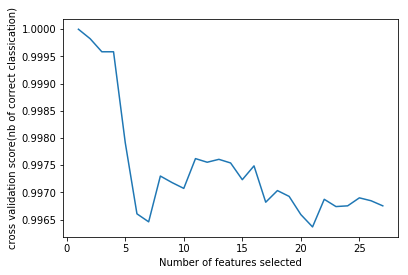

In [53]:
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('cross validation score(nb of correct classication)')
plt.plot(range(1,len(rfecv.grid_scores_) + 1),rfecv.grid_scores_)
plt.savefig('feature.jpg')
plt.show()

特征对比图

In [55]:
X_train.head()

,wind_speed,generator_speed,power,wind_direction,wind_direction_mean,yaw_position,yaw_speed,pitch1_angle,pitch2_angle,pitch3_angle,...,acc_y,environment_tmp,int_tmp,pitch1_ng5_tmp,pitch2_ng5_tmp,pitch3_ng5_tmp,pitch1_ng5_DC,pitch2_ng5_DC,pitch3_ng5_DC,group
288363,-0.957613,-1.172869,-0.843076,1.713161,0.083287,1.492493,0.170338,0.177778,0.204444,0.204444,...,0.061109,-0.293454,-0.635228,0.644615,0.860000,0.583077,0.56,-0.92,1.92,2818
161717,-0.249523,-0.361860,-0.498943,0.247484,0.795081,-1.196717,-0.038964,0.168889,0.204444,0.208889,...,-1.209522,-1.745271,-1.665902,0.936923,1.200000,0.815385,1.32,1.60,-1.64,1578
359170,-1.012932,-1.172869,-0.877126,-1.881114,-1.499885,-0.731058,-0.004080,0.208889,0.222222,0.217778,...,0.061109,-0.989380,-0.767170,0.615385,0.661538,0.907692,-1.60,-0.64,-0.76,3511
91553,0.189345,0.754938,0.130808,-2.034760,-0.952741,-0.678640,0.100571,0.204444,0.137778,0.164444,...,0.061109,-0.689548,-0.348399,1.276923,1.384615,0.583077,-0.60,0.16,0.00,896
23676,-0.625696,-0.547993,-0.577050,-1.138780,-1.104725,1.620532,-0.178499,0.244444,0.275556,0.324444,...,0.061109,0.653383,1.028382,0.629231,1.000000,0.783077,1.92,-0.56,2.08,230


C:\Programs\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


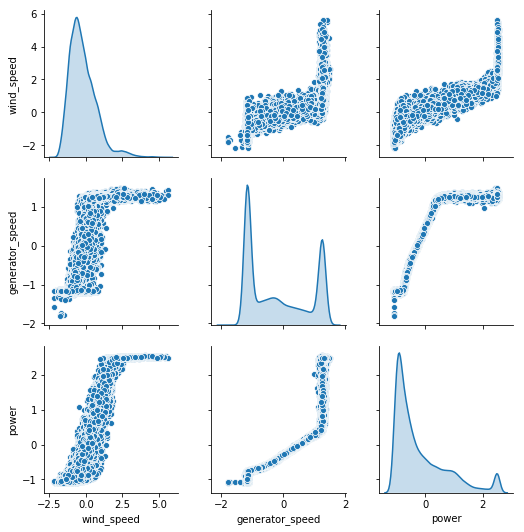

In [56]:
import seaborn as sns
sns.pairplot(X_train,vars=['wind_speed','generator_speed','power'],palette='husl',diag_kind='kde')
plt.savefig('duibi.jpg')

网格搜索随机森林最佳参数

In [57]:
def Gridsearch():
    param_grid = [{
        'n_estimators':[i for i in range(500,510)],
        'oob_score':True,
        'random_state':[i for i in range(30,50)],
        'min_samples_split':[i for i in range(2,20)],
        'max_depth':[i for i in range(100,200)],
    }]
    rf_clf = RandomForestClassifier(max_depth=146,n_estimators=500,
                                   max_leaf_nodes = 25000,oob_score=True)
    grid_search = GridsearchCV(rf_clf,param_grid,n_jobs=-1)
    grid_search.fit(X,y)
    grid_search.best_score_
    grid_search.best_estimator_
    

使用随机森林分类器（直接使用网格搜索的最佳参数）

In [60]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=146,n_estimators=2500,
                                max_leaf_nodes=2500,oob_score=True,
                                random_state=30,n_jobs=-1)
rf_clf.fit(X_train,y_train)
y_predict = rf_clf.predict(X_test)
print(rf_clf.oob_score_)

0.9999866428018059


绘制混淆矩阵

In [ ]:
def plot_confusion_matrix(cm,classes,normalize=False,
                         title='Confusion matrix',
                         cmap = plt.cm.Blues):
    '''
    Normalization can be applied by setting ‘normalize = True‘
    '''
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm = cm.astype('flaoat')/cm.sum